# Анализ рекламных источников мобильной игры

---

## Обзор и предобработка данных

### Сохранение датасетов и обзор общей информации о данных

In [1]:
#импортируем все нужные библиотеки 

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st
import math as mth 
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import statistics
register_matplotlib_converters

<function pandas.plotting._misc.register()>

In [2]:
# сохраняем датасеты

ad_costs = pd.read_csv('/Users/ivansuckov/yp-projects/yp_data_analytics_projects/game_marketing_analytics/ad_costs.csv', parse_dates=['day'])
game_actions = pd.read_csv('/Users/ivansuckov/yp-projects/yp_data_analytics_projects/game_marketing_analytics/game_actions.csv', parse_dates=['event_datetime'])
user_source = pd.read_csv('/Users/ivansuckov/yp-projects/yp_data_analytics_projects/game_marketing_analytics/user_source.csv')    

display(ad_costs.head())
display(game_actions.head())
display(user_source.head())

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [3]:
# выводим общую информацию о датасетах

ad_costs.info()
game_actions.info()
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entrie

***ad_costs***:
- нет пропусков;
- 28 строк - по-вдимому, по семь дней привлечения на четыре источника; 
- названия колонок нас устраивают; 
- типы данных нас устраивают.

***game_actions***:
- в столбцах `building_type` и `project_type` есть пропуски - видимо из-за устройства таблицы: там где пропуск - событие не соответсвует постройке здания или выполнению проекта (также можно сразу сказать, что было построено 127957 зданий и выполнено 1866 проектов;
- названия столбцов нас устраивают. 

***user_source***:
- нет пропусков; 
- названия столбцов нас устраивают; 
- типы данных в порядке; 
- если нет дубликатов, то число строк - это число уникальных пользователей.

---

### Предобработка данных

#### *ad_costs*

В этом датасете нет пропусков. 

Проверим дубликаты:

In [4]:
print(f'количество дубликатов: {ad_costs.duplicated().sum()}')

количество дубликатов: 0


In [5]:
print(f'источники привлечения: {ad_costs["source"].unique()}')

источники привлечения: ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']


In [6]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


---

#### *game_actions*

Проверим пропуски. Наше предположение заключается в том, что пропуски связаны с устройством таблицы и находятся там, где либо не было события постройки, либо не было события завершения уровня. Если это так, то их заполнять не надо и можно оставить как есть.

In [7]:
print(len(game_actions.query('building_type.isnull() & event != "building"')))
print(len(game_actions.query('(event == "finished_stage_1") | (event == "project")')))
print(len(game_actions.query('building_type.isnull() & event == "building"')))

7683
7683
0


Пропуски только там, где не событие - не постройка.

In [8]:
print(len(game_actions.query('project_type.isnull() & event != "project"')))
print(len(game_actions.query('(event == "building") | (event == "finished_stage_1")')))
print(len(game_actions.query('project_type.isnull() & event == "project"')))


133774
133774
0


Пропуски только там, где событие - не проект.

Не будем заполнять пропуски и оставим NaN. 

---

Проверим дубликаты:

In [9]:
game_actions.loc[game_actions.duplicated() == True]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [10]:
game_actions.query('user_id == "c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af"')

,event_datetime,event,building_type,user_id,project_type
15950,2020-05-05 20:34:11,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
24861,2020-05-06 18:44:36,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
42819,2020-05-08 09:43:44,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
46859,2020-05-08 17:39:07,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
59875,2020-05-09 18:14:20,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
63799,2020-05-10 01:01:13,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
73730,2020-05-10 16:58:17,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
99838,2020-05-13 16:47:59,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Действительно, вкрался дубликат - одно и то же действие с точностью до секнуды - наверняка просто техническая ошибка. Удалим его. 

In [11]:
game_actions = game_actions.drop_duplicates()

# проверка. Было 135640 строк
len(game_actions)

135639

Попробуем выявить неявные дубликаты.

In [12]:
game_actions.duplicated(subset=['event_datetime', 'user_id']).sum()

0

Действий в одну и ту же секунду для одного пользователя не нашлось.

In [13]:
pj = game_actions.query('project_type == "satellite_orbital_assembly"')

pj.loc[pj.duplicated(subset=['event_datetime', 'project_type']) == True]

,event_datetime,event,building_type,user_id,project_type
116915,2020-05-16 08:42:42,project,NaN,c2c260e7-f203-4c5a-ad32-e47c2d158476,satellite_orbital_assembly


In [14]:
game_actions.query('event_datetime == "2020-05-16 08:42:42"')

,event_datetime,event,building_type,user_id,project_type
116914,2020-05-16 08:42:42,project,NaN,6639a17f-56e9-4986-8f51-2d5352fd552c,satellite_orbital_assembly
116915,2020-05-16 08:42:42,project,NaN,c2c260e7-f203-4c5a-ad32-e47c2d158476,satellite_orbital_assembly


Два пользователя завершили проект в одно и то же время с точностью до секунды. Нет оснований считать, что это не совпадение, а ошибка.

На всякий случай проверим, не залоггировались ли завершения уровня больше одного раза:

In [15]:
fin_st = game_actions.query('event == "finished_stage_1"')

fin_st.duplicated(subset=['user_id', 'event']).sum()

0

In [16]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


---

#### *user_source*

Данный датасет надо проверить только на дубликаты. 

In [17]:
print(f'количество строк: {len(user_source)}')
print(f'количество уникальных пользователей: {len(user_source["user_id"].unique())}')
print(f'количество дубликатов: {user_source.duplicated().sum()}')

количество строк: 13576
количество уникальных пользователей: 13576
количество дубликатов: 0


---

### Предварительная проверка распределений и поиск аномалий:

#### За какой период есть данные

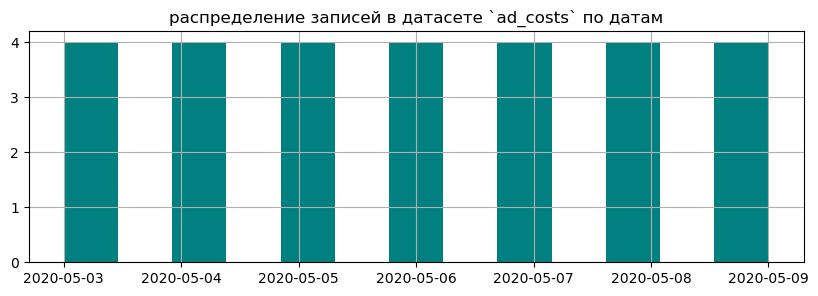

In [18]:
(
ad_costs['day']
.hist(bins=13, figsize=(10, 3), color='teal')
    .set_title('распределение записей в датасете `ad_costs` по датам')
);

In [19]:
print(f"минимальная дата в ad_costs: {ad_costs['day'].dt.date.min()}")
print(f"максимальная дата в ad_costs: {ad_costs['day'].dt.date.max()}")

минимальная дата в ad_costs: 2020-05-03
максимальная дата в ad_costs: 2020-05-09


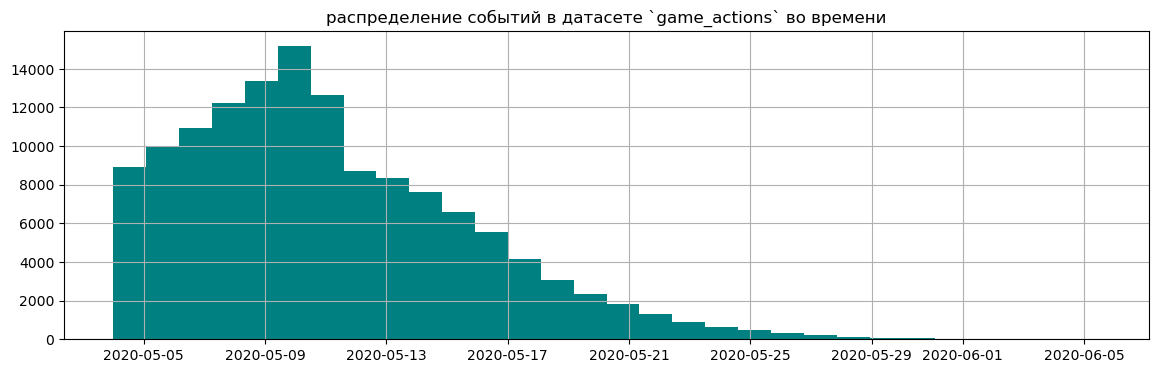

In [20]:
(
game_actions['event_datetime']
.hist(bins=30, figsize=(14, 4), color='teal')
    .set_title('распределение событий в датасете `game_actions` во времени')
);

In [21]:
print(f"минимальная дата в game_actions: {game_actions['event_datetime'].dt.date.min()}")
print(f"максимальная дата в game_actions: {game_actions['event_datetime'].dt.date.max()}")

минимальная дата в game_actions: 2020-05-04
максимальная дата в game_actions: 2020-06-05


На графике видно резкое падение активности где-то между 9 и 13 мая. Вероятно, это связано с тем, что в датасете активность только тех пользователей, которые были привлечены с 3 по 9 мая, соответственно после окончания привлечения активность резко падает. (В данном случае даты будут сдвигаться на один день - будем считать, что за пользователей, пришедших 4 мая, заплатили на день раньше - 3 мая). Так, пиковый день актвиности должно быть 10 мая. Проверим это:

In [22]:
print(f"пиковый день активности: {statistics.mode(game_actions['event_datetime'].dt.date)}")

пиковый день активности: 2020-05-10


---

Чтобы не запутаться в датах привлечения, добавим по одному дню к каждой дате в *ad_costs*:

In [23]:
ad_costs['day'] = ad_costs['day'].map(lambda x: x + timedelta(days=1))

# проверка
print(f"новая минимальная дата в ad_costs: {ad_costs['day'].dt.date.min()}")
print(f"новая максимальная дата в ad_costs: {ad_costs['day'].dt.date.max()}")

новая минимальная дата в ad_costs: 2020-05-04
новая максимальная дата в ad_costs: 2020-05-10


---

#### распределение значений в числовых колонках (`cost` в *ad_costs*)

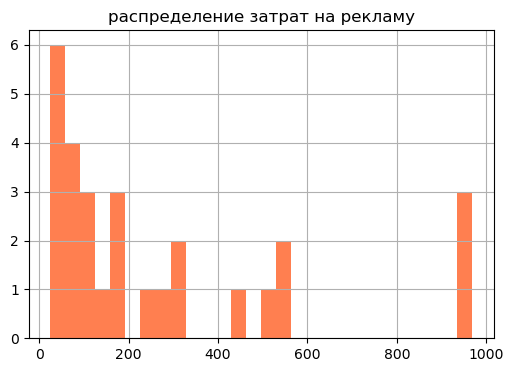

In [25]:
(
ad_costs['cost']
.hist(bins=28, figsize=(6, 4), color='coral')
    .set_title('распределение затрат на рекламу')
);

Затраты на рекламу достаточно сильно разнились - есть три достаточно высоких по сравнению с другими значения, но пока нельзя сказать, что это аномалия или выброс. 

---

### Итоги предобработки

- Мы сохранили датасеты в переменных *ad_costs, game_actions и user_source.*
- В датасете *ad_costs* заменили даты на более удобные. 
- В датасете *game_actions* нашли один дубликат и удостоверились, что неявных дубликатов нет, а пропуски можно оставить как есть. Всего в датасете 135639 уникальных событий. 
- В датасете *user_source* не потребовалось производить изменения. Всего в датасете 13576 уникальных пользователей. 
- Мы также посмотрели как распределены даты в *game_actions* - у нас есть действия пользователей с 10 мая по 5 июня, а пиковая активность приходится на 10 мая - последний день привлечения пользователей. 

---
---

## Исследовательский анализ данных:

- Общие статистики по датасетам;
- Сколько всего пользователей; сколько событий приходится на уникального пользователя; 
- Поведение пользователей: 
    - конверсия привлеченных пользователей в прошедших первый уровень: 
        - сколько пользователей сумело завершить первый уровень;
        - сколько пользователей завершило первый уровень способом победы над врагом, а сколько - выполненением проекта; 
    - как долго пользователи проходили первый уровень; 
    - сколько зданий строят пользователи; 
    - как распределены типы зданий среди пользователей;
    - определение корреляции между:
        - временем прохождения и количеством событий; 
        - временем прохождения и типом завершения первого уровня;
- Исследование каналов привлечения: 
    - какие каналы привлечения использовались и в каком соотношении по числу привлеченных пользователей; 
    - рассчет метрики САС в целом;
    - рассчет метрики САС в разбивке по каналам;
    - динамика САС по дням в целом; 
    - динамика САС по дням в разбивке по каналам;
- Предварительные выводы по исследовательскому анализу данных.

###  Общие статистики по датасетам

In [26]:
ad_costs.describe()

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


Средняя стоимость привлечения (271) достаточно сильно отличается от медианной (160). Виной тому несколько значений с максимальной стоимостью - 969. Минимальная стоимость была - 23. 

В остальных датасетах нет числовых значений, так что изучим статистики общие статистики позже.

In [27]:
game_actions.describe()

/var/folders/31/0kmsg96n1s76p6j1v4ycwtz00000gn/T/ipykernel_74324/3003618796.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  game_actions.describe()


,event_datetime,event,building_type,user_id,project_type
count,135639,135639,127956,135639,1866
unique,128790,3,3,13576,1
top,2020-05-09 21:49:07,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127956,59325,22,1866
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


Всего 135639 событий, самое частое - постройка. Чаще всего строили 'spaceport'. 13576 пользователей, 1866 из них завершили уровень выполнением проекта. 

In [28]:
user_source.describe()

,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


Больше всего событий - от игроков из источника 'yandex_direct'.

---

### Датафрейм с профилями пользователей

Чтобы упростить дальнейшие рассчеты, соберем информацию об уникальных пользователях в один датафрейм. 

In [29]:
# делаем таблицу и добавляем колонки со временем и датой

users_time = (
    game_actions
    .pivot_table(index='user_id', values='event_datetime', aggfunc=('min', 'max'))
    .reset_index()
)
users_time['hours'] = round((users_time['max'] - users_time['min']).dt.total_seconds() / 3600)

users_time['first_date'] = users_time['min'].dt.date

In [30]:
# добавляем количество событий

user_events = (
    game_actions
    .pivot_table(index='user_id', values='event', aggfunc='count')
    .reset_index()
    .rename(columns={'event': 'number_of_events'})
)


users_time = users_time.merge(user_events, on='user_id')

In [31]:
# добавляем количество зданий

user_buildings = (
    game_actions
    .query('event == "building"')
    .pivot_table(index='user_id', values='event', aggfunc='count')
    .reset_index()
    .rename(columns={'event': 'number_of_buildings'})
)

users = users_time.merge(user_buildings, on='user_id')

Определим, кто из пользователей каким способом закончил уровень: если у пользователя есть 'finished_stage_1' в колонке `event` и есть 'satellite_orbital_assembly' в `project_type`, то уровень завершен посредством сборки спутника; если 'finished_stage_1' есть, но нет 'satellite_orbital_assembly', то уровень завершен победой над врагом. 

In [32]:
# списки с пользвателями по типу прохождения

all_users = game_actions['user_id'].unique()
first_lvl_finished = list(game_actions.query('event == "finished_stage_1"')['user_id'].unique())
first_lvl_not_finished = list(game_actions.query('~user_id.isin(@first_lvl_finished)')['user_id'].unique())
pve = list(game_actions.query('project_type == "satellite_orbital_assembly"')['user_id'])
pvp = list(
    game_actions
    .query('user_id.isin(@first_lvl_finished) & ~user_id.isin(@pve)')['user_id']
    .unique()
)

In [33]:
# добавляем тип прохождения

users['level_finished'] = (
    users['user_id']
    .apply(lambda x: 'not_finished' if x in first_lvl_not_finished else ('pve' if x in pve else 'pvp'))
)

In [34]:
# добавляем источник перехода

users = users.merge(user_source, on='user_id')

In [37]:
# проверка

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              13576 non-null  object        
 1   max                  13576 non-null  datetime64[ns]
 2   min                  13576 non-null  datetime64[ns]
 3   hours                13576 non-null  float64       
 4   first_date           13576 non-null  object        
 5   number_of_events     13576 non-null  int64         
 6   number_of_buildings  13576 non-null  int64         
 7   level_finished       13576 non-null  object        
 8   source               13576 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 1.0+ MB


,user_id,max,min,hours,first_date,number_of_events,number_of_buildings,level_finished,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-20 11:26:06,2020-05-06 01:07:37,346.0,2020-05-06,13,13,not_finished,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-18 10:46:52,2020-05-06 03:09:12,296.0,2020-05-06,9,9,not_finished,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-14 09:21:27,2020-05-05 18:08:52,207.0,2020-05-05,4,4,not_finished,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-12 07:40:47,2020-05-05 21:02:05,155.0,2020-05-05,9,8,pvp,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-22 02:46:45,2020-05-05 13:49:58,397.0,2020-05-05,12,12,not_finished,facebook_ads


Для краткости мы пометили пользователей, завершивших уровень постройкой спутника меткой *pve*. Тех, кто победил врага - *pvp*. Тех, кто не закончил уровень - *not_finished*.

### Количество уникальных пользователей. Сколько событий приходится на уникального пользователя

In [38]:
print(f'количество уникальных пользователей в датасете game_actions: {len(game_actions["user_id"].unique())}')
print(f'количество уникальных пользователей в датасете user_source: {len(user_source["user_id"].unique())}')

количество уникальных пользователей в датасете game_actions: 13576
количество уникальных пользователей в датасете user_source: 13576


In [39]:
avg_events_per_user = users['number_of_events'].mean()
max_events_per_user = users['number_of_events'].max()
min_events_per_user = users['number_of_events'].min()

print(f'среднее число событий на уникального пользователя: {round(avg_events_per_user)}')
print(f'максимальное число событий на уникального пользователя: {max_events_per_user}')
print(f'минимальное число событий на уникального пользователя: {min_events_per_user}')

среднее число событий на уникального пользователя: 10
максимальное число событий на уникального пользователя: 22
минимальное число событий на уникального пользователя: 1


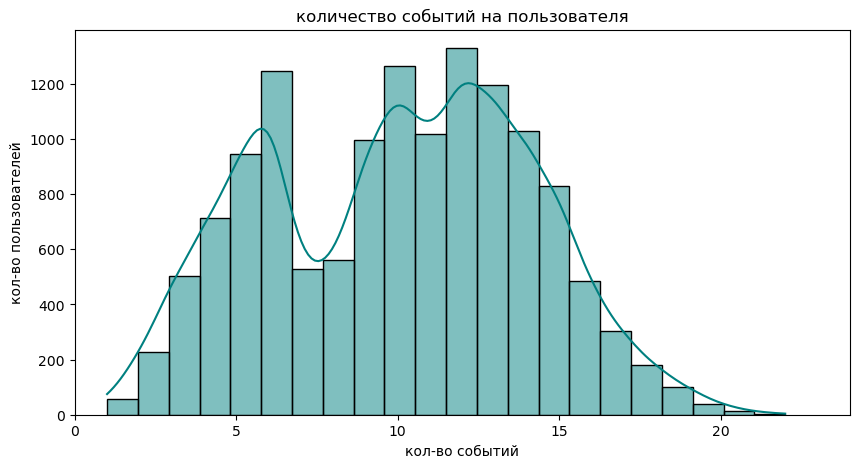

In [40]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(x='number_of_events', data=users, kde=True, color='teal', bins=22)
plt.xlim(0, 24)
plt.xlabel('кол-во событий')
plt.ylabel('кол-во пользователей')
plt.title('количество событий на пользователя');

Чаще всего на пользователя приходится 6, 10 или 12 событий. Пока трудно сказать, с чем связан "провал" в частоте событий между 6 и 9 - возможно дело в механике игры - некоторые из тех, кто дошел до 6 событий, дальше бросают играть.

---

### Поведение пользователей

#### Конверсия привлеченных пользователей в прошедших первый уровень

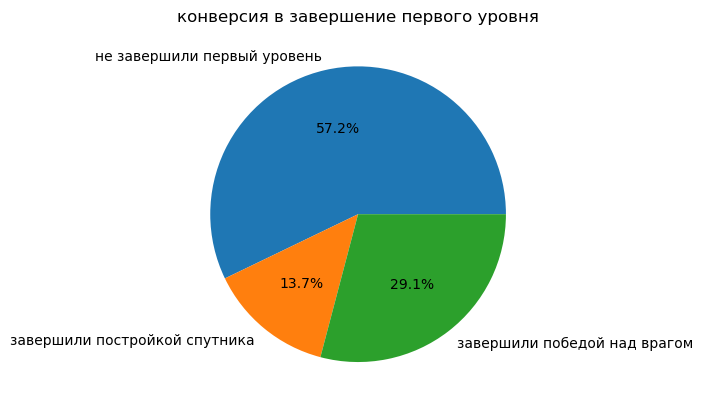

In [41]:
values = [len(first_lvl_not_finished), len(pve), len(pvp)]
labels = ['не завершили первый уровень', 'завершили постройкой спутника', 'завершили победой над врагом']

plt.title('конверсия в завершение первого уровня')
plt.pie(values, labels=labels, autopct='%1.1f%%');

Так как большинство пользователей не завершили первый уровень вообще, а всего 13% пользователей завершили уровень постройкой спутника, то предварительно можно сделать вывод о том, что постройка спутника - либо самый неинтересный, либо самый сложный способ. 

---

#### Как долго пользователи проходили первый уровень

Началом прохождения первого уровня будем считать первое действие, а концом прохождения - самое последнее (есть пользователи, которые успевали совершать несколько действий после события 'first_lvl_finished').


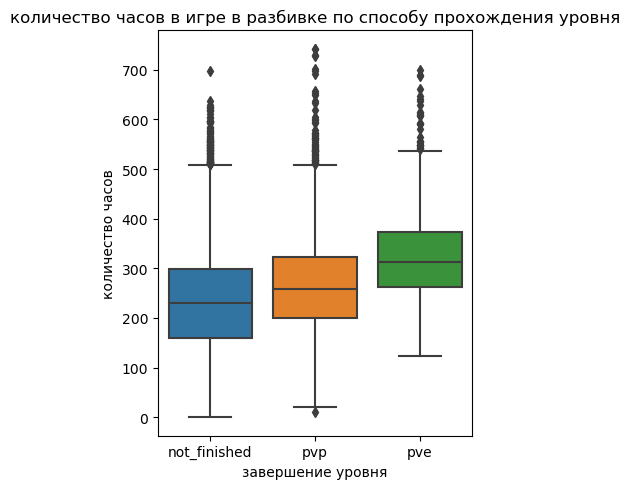

In [42]:
fig = plt.figure(figsize=(4, 5))
ax = sns.boxplot(data=users, x='level_finished', y='hours')
ax.set_title('количество часов в игре в разбивке по способу прохождения уровня')
ax.set(xlabel='завершение уровня')
ax.set(ylabel='количество часов')
plt.tight_layout()
plt.show();

In [43]:
users.pivot_table(index='level_finished', values='hours', aggfunc='mean').reset_index()

,level_finished,hours
0,not_finished,234.918546
1,pve,323.011790
2,pvp,266.507213


In [44]:
users.pivot_table(index='level_finished', values='hours', aggfunc='min').reset_index()

,level_finished,hours
0,not_finished,0.0
1,pve,123.0
2,pvp,10.0


- Частично можно подтвердить предположение, выдвинутое ранее - для постройки спутника нужно в среднем заметно больше часов, чем для того, чтобы пройти уровень сражением;
- Видимо, трудность этого способа заключается в том, что он просто дольше; 
- Среди пользователей, закончивших уровень постройкой спутника, вообще нет значений ниже 100 часов между первым и последним действием;
- Минимальное количество часов для прохождения мирным путем - 123, путем победы над врагом - 10.

---

#### Сколько событий приходится на пользователя

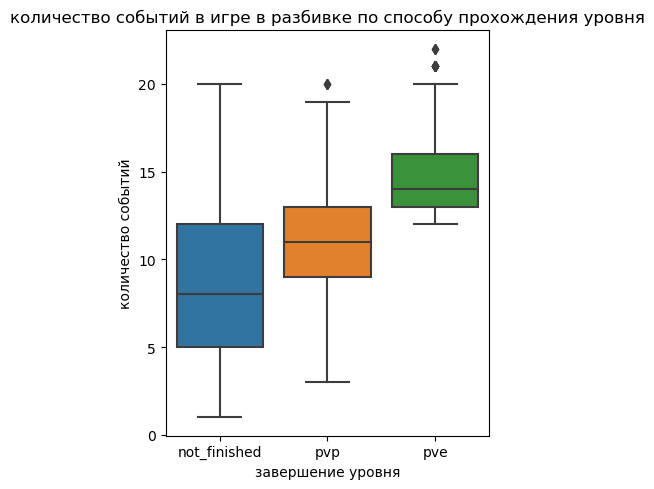

In [45]:
fig = plt.figure(figsize=(4, 5))
ax = sns.boxplot(data=users, x='level_finished', y='number_of_events')
ax.set_title('количество событий в игре в разбивке по способу прохождения уровня')
ax.set(xlabel='завершение уровня')
ax.set(ylabel='количество событий')
plt.tight_layout()
plt.show();

In [46]:
users.pivot_table(index='level_finished', values='number_of_events', aggfunc='mean').reset_index()

,level_finished,number_of_events
0,not_finished,8.657043
1,pve,14.647910
2,pvp,10.411541


In [47]:
users.pivot_table(index='level_finished', values='number_of_events', aggfunc='min').reset_index()

,level_finished,number_of_events
0,not_finished,1
1,pve,12
2,pvp,3


- В среднем мирные игроки совершали больше событий (14 против 10 для воинственных);
- Верхняя граница нормальных значений для пользователей не завершивших первый уровень примерно на том же уровне, что и для не завершивших - быть может пользователи столкнулись с каким-то техническими трудностями или им просто надоело играть? 
- Минимальное число событий для прохождения постройкой спутника - 12, для победы над врагом - 3.

---

#### Сколько зданий строят пользователи

In [48]:
# функция для отображения значений на графике

def show_values(axs, orient="v", space=.01):
    '''
    Функция помогает добавить на график значения столбцов. 
    Функция принимает переменную с графиком, 
    значение ориентации графика и значение расстояния изображаемого значения от столбца.    
    '''
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

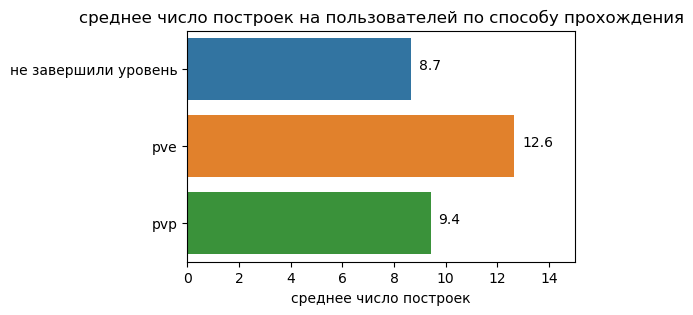

In [49]:
values = [
    users.query('level_finished =="not_finished"')['number_of_buildings'].mean(), 
    users.query('level_finished =="pve"')['number_of_buildings'].mean(), 
    users.query('level_finished =="pvp"')['number_of_buildings'].mean()
]

labels = [
    'не завершили уровень',
    'pve', 
    'pvp'   
]

fig = plt.figure(figsize=(5, 3))

ax = sns.barplot(x=values,
                 y=labels)
ax.set_title('среднее число построек на пользователей по способу прохождения')
ax.set(xlabel='среднее число построек')
ax.set(ylabel='')
ax.set(xlim=(0, 15))
show_values(ax, "h", space=0.3)

- Больше всего строят те, кто выбрал мирный путь завершения уровня;
- Закономерно, что меньше всего построек у тех, кто уровень не завершил, однако разница не такая большая.

---

#### Как распределены типы зданий среди пользователей

In [51]:
buildings = game_actions.pivot_table(index=('user_id','building_type') , values='event', aggfunc='count').reset_index()
buildings_users = buildings.merge(users, on='user_id')
buildings_users = buildings_users.pivot_table(index=('building_type', 'level_finished'), values='event', aggfunc='mean').reset_index()
buildings_users = buildings_users.sort_values(by='event', ascending=False)
buildings_users['event'] = round(buildings_users['event'], 2)
buildings_users

,building_type,level_finished,event
7,spaceport,pve,5.78
1,assembly_shop,pve,4.89
8,spaceport,pvp,4.40
6,spaceport,not_finished,4.20
2,assembly_shop,pvp,4.13
0,assembly_shop,not_finished,3.75
4,research_center,pve,1.98
3,research_center,not_finished,1.93
5,research_center,pvp,1.60


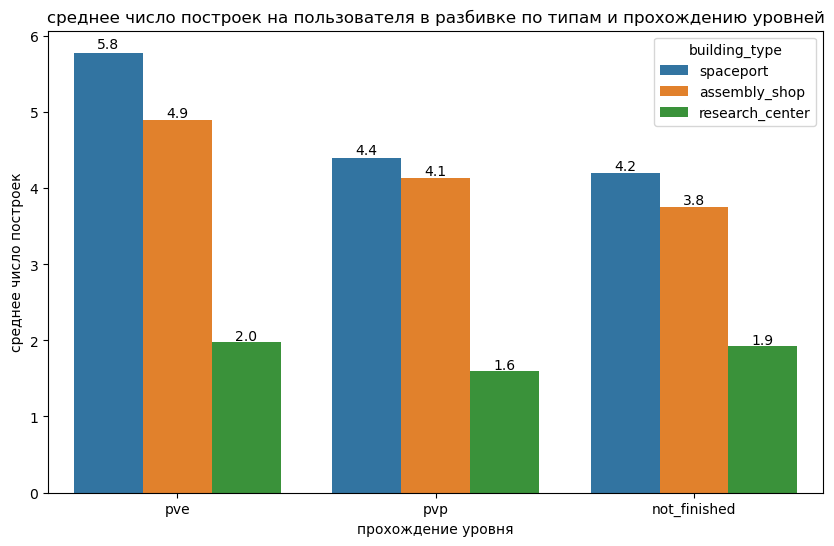

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='level_finished',y='event',data=buildings_users,hue='building_type')
ax.set_title('среднее число построек на пользователя в разбивке по типам и прохождению уровней')
ax.set(xlabel='прохождение уровня')
ax.set(ylabel='среднее число построек')
show_values(ax, "v")
plt.show()

- Среднее число построек для всех типов выше всего у пользователей, которые строили спутник;
- Самое низкое среднее значение для всех типов, кроме 'research_center' - среди пользователей, не завершивших уровень; 
- Самое большое значение среднего числа построек у 'spaceport' для тех, кто завершил уровень мирно - это закономерно, потому что они и строят больше и спутник как-то надо отправлять в космос;
- Не самое низкое среднее значение 'research_center' для пользвоателей, не прошедших первый уровень, - это может быть инересным инсайтом для заказчика: пользователи достаточно много строили здания такого типа, но все равно не прошли уровень - может быть они столкнулись с какими-либо трудностями или им стало неинтересно так долго продолжать игру? 

---

#### Корреляция между временем прохождения и количеством событий

Предположим, что корреляция должна быть такой: чем больше событий, тем больше времени между первым и последним действием.

In [53]:
corr = users['number_of_events'].corr(users['hours'])
print(f'коэф. корреляции между кол-вом событий и часов между первым и последним событием для всех пользователей: {round(corr, 3)}')


коэф. корреляции между кол-вом событий и часов между первым и последним событием для всех пользователей: 0.591


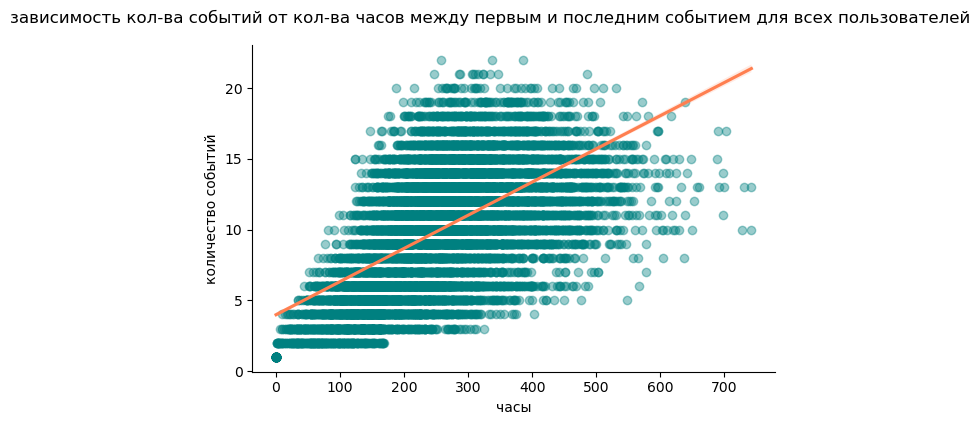

In [54]:
lm = (
    sns.lmplot(
    data=users, x="hours", y="number_of_events",
    height=4, aspect=1.5, 
    scatter_kws={'color': 'teal', 'alpha':0.4}, line_kws={'color': 'coral'}
).set_axis_labels('часы', 'количество событий')
    .fig
    .suptitle("зависимость кол-ва событий от кол-ва часов между первым и последним событием для всех пользователей", y=1.05)
);


Ожидаемо, зависимость достаточно большая.

In [55]:
corr = (
    users.query('level_finished =="not_finished"')['number_of_events']
    .corr(users.query('level_finished =="not_finished"')['hours'])
)
print(f'коэф. корреляции между кол-вом событий и часов между первым и последним событием для пользователей, не завершивших первый уровень: {round(corr, 3)}')


коэф. корреляции между кол-вом событий и часов между первым и последним событием для пользователей, не завершивших первый уровень: 0.616


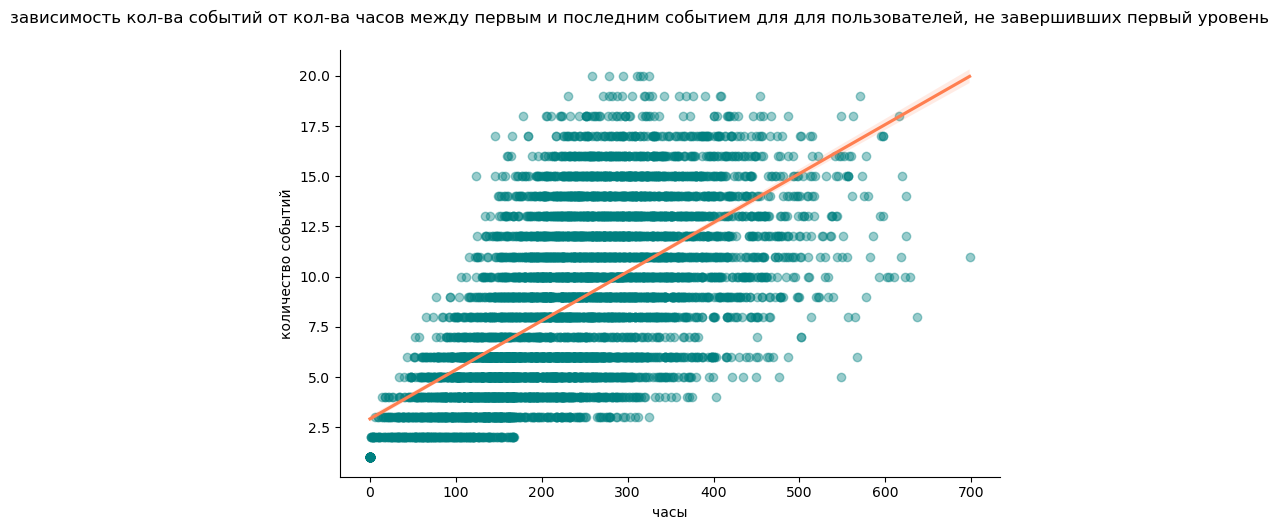

In [56]:
lm = (
    sns.lmplot(
    data=users.query('level_finished =="not_finished"'), x="hours", y="number_of_events",
    height=5, aspect=1.5, 
    scatter_kws={'color': 'teal', 'alpha':0.4}, line_kws={'color': 'coral'}
).set_axis_labels('часы', 'количество событий')
    .fig
    .suptitle("зависимость кол-ва событий от кол-ва часов между первым и последним событием для для пользователей, не завершивших первый уровень", y=1.05)
);


Коэффициент корреляции даже выше, чем для по всему датасету в целом. 

Проверим зависимости для пользователей, прошедших первый уровень первым или вторым способом. 

In [57]:
corr = (
    users.query('level_finished =="pve"')['number_of_events']
    .corr(users.query('level_finished =="pve"')['hours'])
)
print(f'коэф. корреляции между кол-вом событий и часов между первым и последним событием для pve: {round(corr, 3)}')

corr = (
    users.query('level_finished =="pvp"')['number_of_events']
    .corr(users.query('level_finished =="pvp"')['hours'])
)
print(f'коэф. корреляции между кол-вом событий и часов между первым и последним событием для pvp: {round(corr, 3)}')


коэф. корреляции между кол-вом событий и часов между первым и последним событием для pve: 0.076
коэф. корреляции между кол-вом событий и часов между первым и последним событием для pvp: 0.477


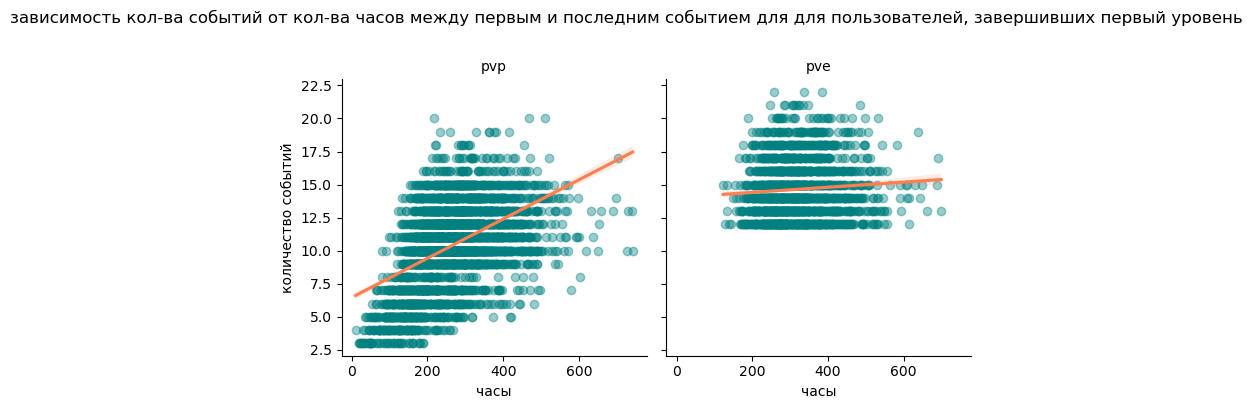

In [58]:
lm = (
    sns.lmplot(
    data=users.query('level_finished != "not_finished"'), x="hours", y="number_of_events",
    col="level_finished", height=4, aspect=0.9, 
    col_wrap=2, scatter_kws={'color': 'teal', 'alpha':0.4}, line_kws={'color': 'coral'}
).set_axis_labels('часы', 'количество событий')
    .set_titles(col_template="{col_name}")
    .fig
    .suptitle("зависимость кол-ва событий от кол-ва часов между первым и последним событием для для пользователей, завершивших первый уровень", y=1.01)
)
plt.tight_layout();

- Для пользователей, завершивших уровень постройкой спутника не обнаружена зависимость времени от количества событий, однако в целом количество событий больше, чем у завершивших победой на врагом; к тому же видно, что для того, чтобы завершить уровень первым способом нужно больше 11 событий, значения ниже этого уровня отсутсвуют; 
- Для пользователей, завершивших уровень победой, бывало достаточно и трех событий. 
- Среди количества событий пользователей, завершивших уровень победой, наблюдается достаточно большая корреляция между количеством событий и часами в игре.
---

#### Группировка пользователей по датам привлечения

##### Количество пользователей по датам привлечения

In [59]:
number_of_users_by_first_dates = (
    users
    .pivot_table(index='first_date', values='user_id', columns='level_finished', aggfunc='count')
    .sort_values(by='first_date', ascending=False)
)

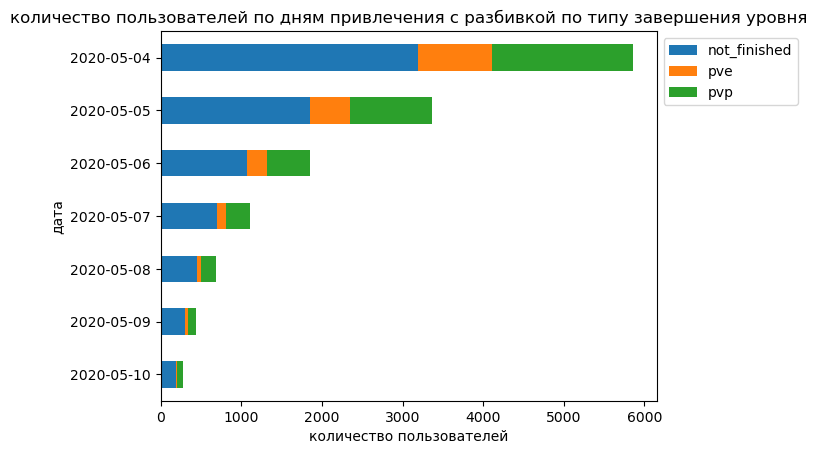

In [60]:
ax = (
    number_of_users_by_first_dates
    .plot(
        kind = 'barh', 
        stacked=True, 
        title='количество пользователей по дням привлечения с разбивкой по типу завершения уровня')
)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(ylabel='дата')
ax.set(xlabel='количество пользователей')
plt.show();

In [61]:
number_of_users_by_first_dates_share = (
    round(users.groupby(['first_date', 'level_finished'])['user_id'].count()/
    users.groupby(['first_date'])['level_finished'].count() * 100, 2)
)
number_of_users_by_first_dates_share = (
    pd.DataFrame(number_of_users_by_first_dates_share.unstack())
    .sort_values(by='first_date', ascending=False)
)

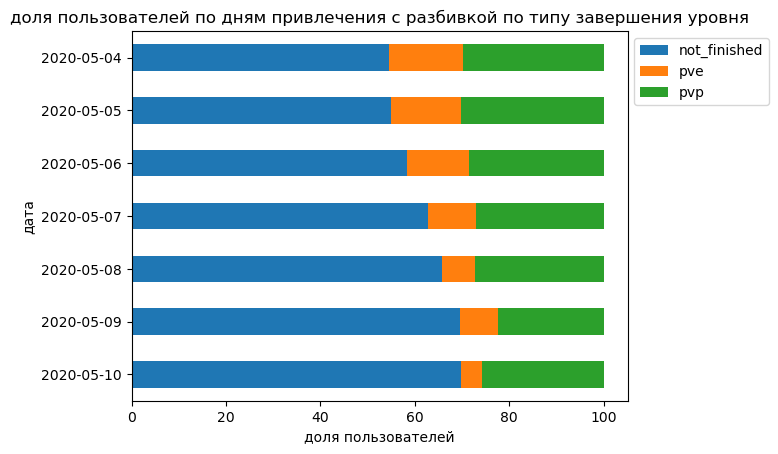

In [85]:
ax = (
    number_of_users_by_first_dates_share
    .plot(
        kind = 'barh', 
        stacked=True, 
        title='доля пользователей по дням привлечения с разбивкой по типу завершения уровня')
)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(ylabel='дата')
ax.set(xlabel='доля пользователей')
plt.show();

- Общее количество привлеченных пользоваетелй падает изо дня в день;
- Доля не закончивших уровень пользователей растет изо дня в день;
- Доля мирных пользователей сокращается изо дня в день (кроме 9 мая); 
- Доля воинственных пользователей слегка колеблется, но остается примерно на одном уровне для каждого дня привлечения.

---

##### Среднее количество событий на пользователя по датам привлечения

In [63]:
avg_event_by_first_date = (
    users
    .pivot_table(index='first_date', columns='level_finished', values='number_of_events', aggfunc='mean')
    .reset_index()
    .sort_values(by='first_date', ascending=False)
)

avg_event_by_first_date = avg_event_by_first_date.sort_values(by='first_date')

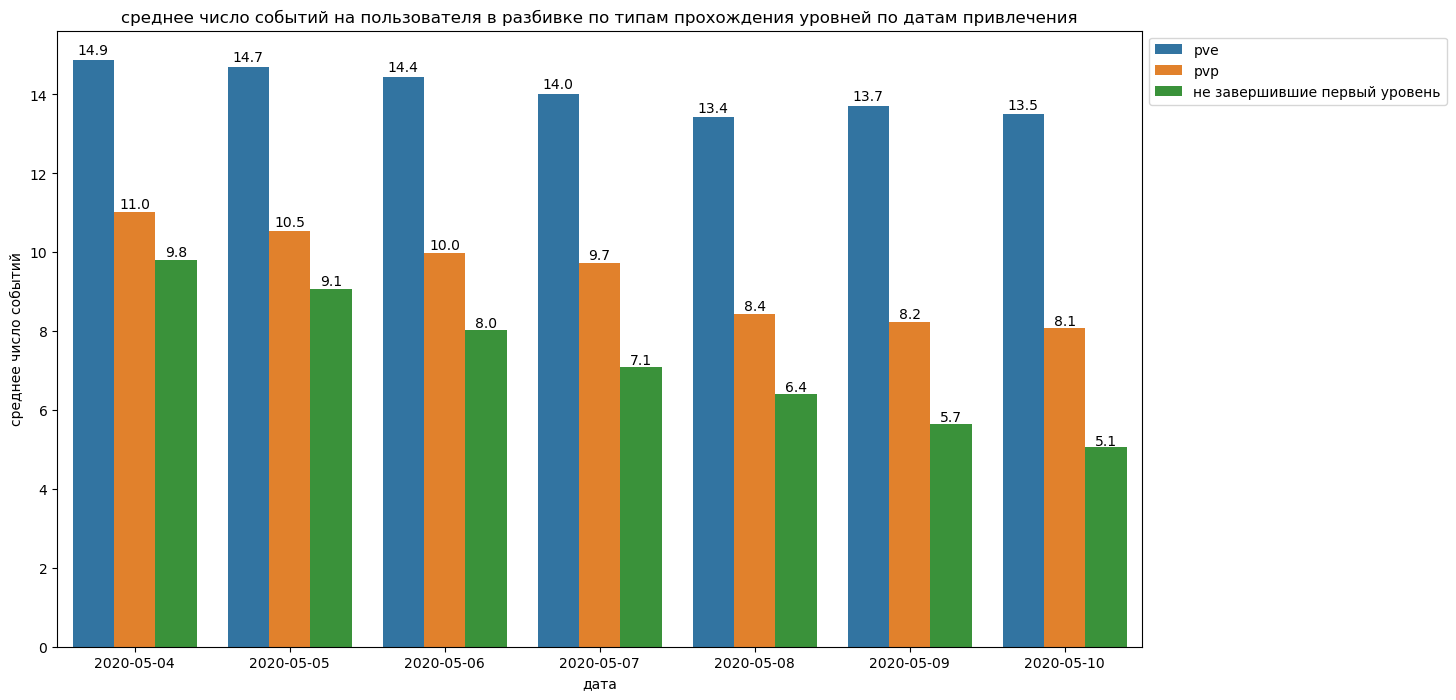

In [64]:
nf = avg_event_by_first_date[['first_date', 'not_finished']]
nf = nf.rename(columns={'not_finished': 'avg_events'})

pve = avg_event_by_first_date[['first_date', 'pve']]
pve = pve.rename(columns={'pve': 'avg_events'})

pvp = avg_event_by_first_date[['first_date', 'pvp']]
pvp = pvp.rename(columns={'pvp': 'avg_events'})

nf['users']='не завершившие первый уровень'
pve['users']='pve'
pvp['users']='pvp'
df = pd.concat([pvp,pve,nf])
df = df.sort_values(by=['first_date', 'avg_events'], ascending=[True, False])

fig = plt.figure(figsize=(14, 8))
ax = sns.barplot(x='first_date',y='avg_events',data=df,hue='users')
ax.set_title('среднее число событий на пользователя в разбивке по типам прохождения уровней по датам привлечения')
ax.set(xlabel='дата')
ax.set(ylabel='среднее число событий')
show_values(ax, "v")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()



В целом среднее число cобытий несколько снижается от даты к дате для всех типов прохождения уровня, но особенно для тех, кто не прошел первый уровень.

---

### Исследование каналов привлечения: 

#### Распределение числа пользователей по каналам

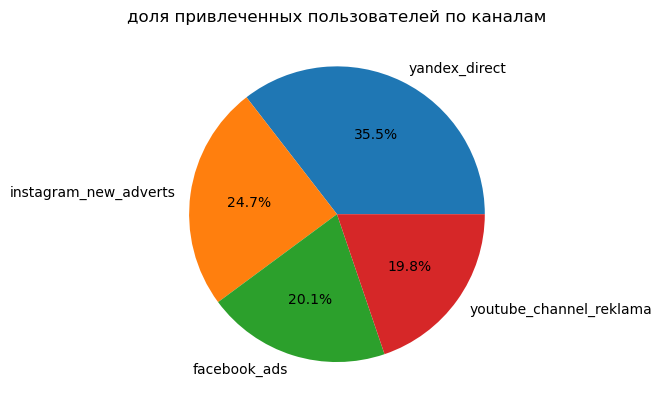

In [66]:
users_by_source = (
    users
    .pivot_table(index='source', values='user_id', aggfunc='count')
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)

plt.title('доля привлеченных пользователей по каналам')
plt.pie(users_by_source['user_id'], labels=users_by_source['source'], autopct='%1.1f%%');

Посмотрим, менялись ли доли по дням. 

In [67]:
users_by_source_by_day = (
    round(users.groupby(['first_date', 'source'])['user_id'].count()/
    users.groupby(['first_date'])['source'].count() * 100, 2)
)
users_by_source_by_day = (
    pd.DataFrame(users_by_source_by_day.unstack())
    .sort_values(by='first_date', ascending=False)
)

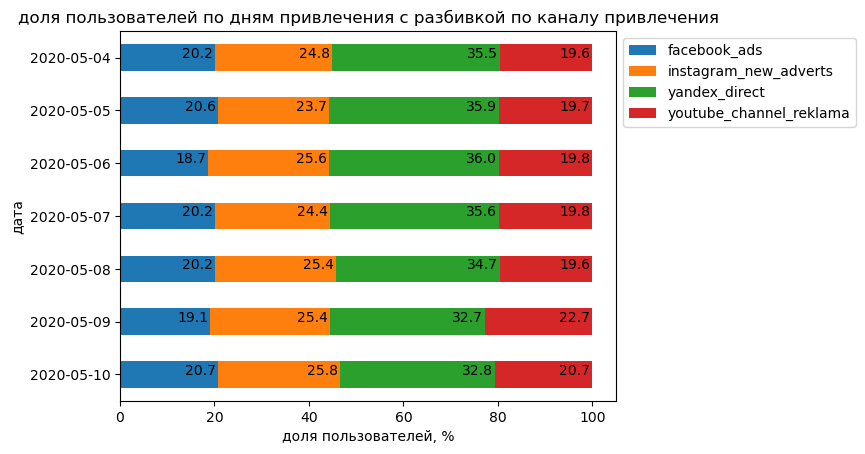

In [68]:
ax = (
    users_by_source_by_day
    .plot(
        kind = 'barh', 
        stacked=True, 
        title='доля пользователей по дням привлечения с разбивкой по каналу привлечения')
)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.set(ylabel='дата')
ax.set(xlabel='доля пользователей, %')
show_values(ax, orient="h", space=-7)
plt.show();

- доли практически не менялись;
- стабильно наибольшая доля - у Yandex; 
- разница между тремя остальными каналами - в целом не больше 5%.
---

#### Расходы на привлечение 

In [86]:
total_costs = ad_costs['cost'].sum().astype(int)
print(f'общая сумма расходов: {total_costs}')

общая сумма расходов: 7603


In [87]:
costs_by_source = (
    ad_costs
    .groupby('source')
    .agg({'cost': 'sum'})
    .sort_values('cost', ascending=False).reset_index()
)
costs_by_source['share, %'] = (costs_by_source['cost']/total_costs).round(3)*100


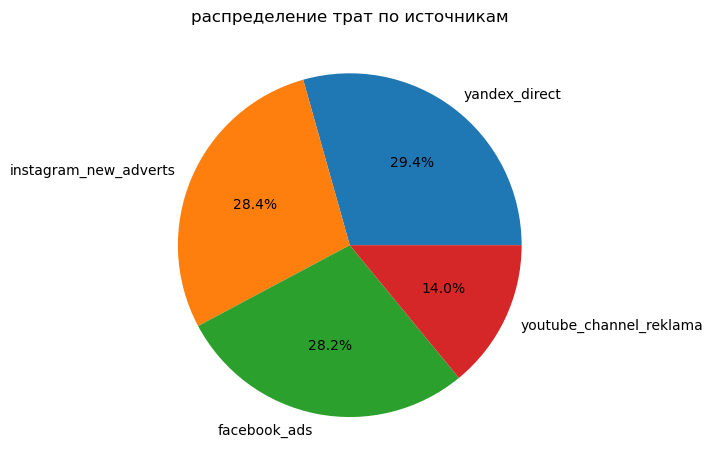

In [88]:
labels = list(costs_by_source['source'])
values = list(costs_by_source['cost'])
plt.title('распределение трат по источникам')
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.tight_layout();

Распределение расходов отличается от распределения количества привлеченных пользователей. Это повлияет на метрику САС. 

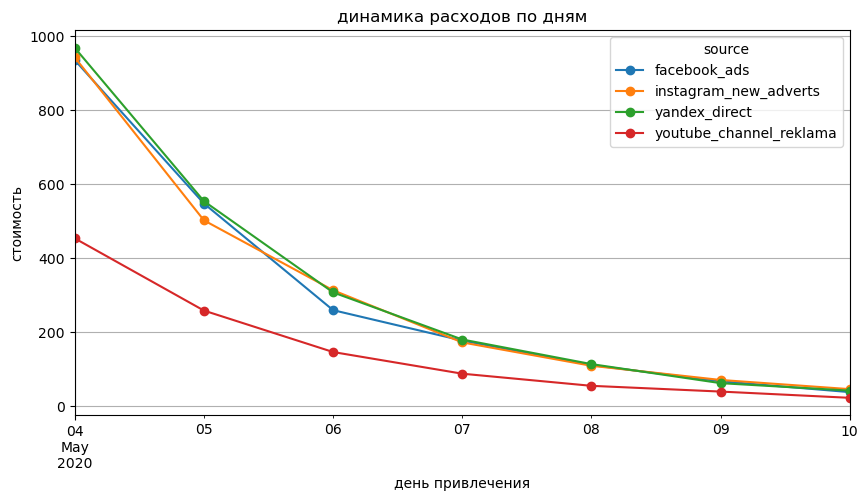

In [91]:
ad_costs.pivot_table(
    index='day',  
    columns='source',  
    values='cost',  
    aggfunc='sum' 
).plot(figsize=(10, 5), grid=True, style='-o')

plt.ylabel('стоимость')
plt.xlabel('день привлечения')
plt.title('динамика расходов по дням')
plt.show()

Стоимость падала день ото дня, но стоимость для источника 'youtube_channel_reklama' изначально была ниже остальных.

#### Рассчет метрики САС

In [90]:
print(f'общий показатель САС: {round(total_costs /  len(users), 2)}')

общий показатель САС: 0.56


Средний САС по источнику привелчения:

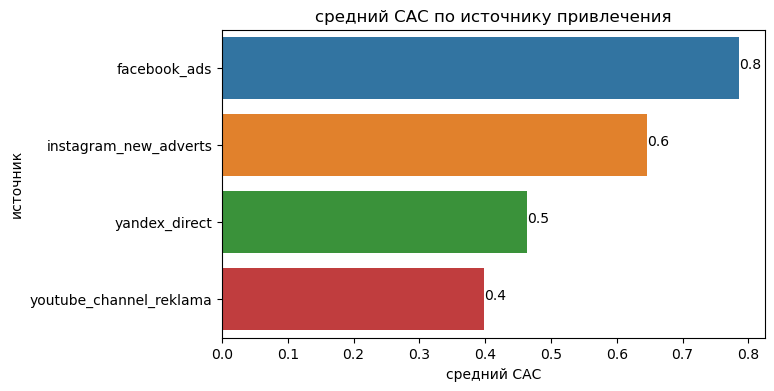

In [92]:
avg_cac = (
    ad_costs
    .pivot_table(index='source', values='cost', aggfunc='sum')
    .reset_index()
)

number_of_users = (
    users
    .pivot_table(index='source', values='user_id', aggfunc='count')
    .reset_index()
)

avg_cac = avg_cac.merge(number_of_users, on='source')

avg_cac['avg_cac'] = avg_cac['cost'] / avg_cac['user_id']


fig = plt.figure(figsize=(7, 4))
ax = sns.barplot(y=avg_cac['source'],
                 x=avg_cac['avg_cac'])
ax.set_title('средний САС по источнику привлечения')
ax.set(xlabel='средний САС')
ax.set(ylabel='источник')
show_values(ax, "h", space=0);

В среднем дешевле всего обходятся пользователи, привлекаемые через канал 'youtube_channel_reklama'. Дороже всего - 'facebook_ads'.

In [93]:
users_by_date_source =(
    users
    .pivot_table(index=('first_date', 'source'), values='user_id', aggfunc='count')
    .reset_index()
)

users_by_date_source = users_by_date_source.rename(columns={'first_date':'day'}) 

ad_costs['day'] = ad_costs['day'].dt.date

ad_costs_users = ad_costs.merge(users_by_date_source, on=['day', 'source'])

ad_costs_users['cac'] = ad_costs_users['cost'] / ad_costs_users['user_id']

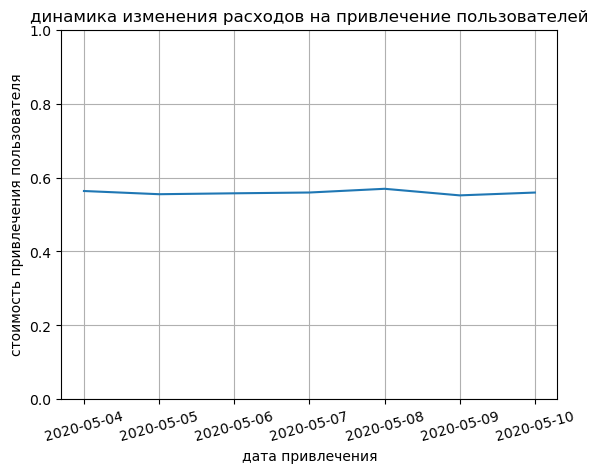

In [94]:
cac_by_day = (
    ad_costs_users
    .pivot_table(index='day', values=('cost', 'user_id'), aggfunc='sum')
    .reset_index()
)

cac_by_day['cac'] = cac_by_day['cost'] / cac_by_day['user_id']


sns.lineplot(data=cac_by_day, x="day", y="cac")

plt.ylabel('стоимость привлечения пользователя')
plt.xlabel('дата привлечения')
plt.title('динамика изменения расходов на привлечение пользователей')
plt.grid()
plt.xticks(rotation = 15)
plt.ylim(0, 1)
plt.show()

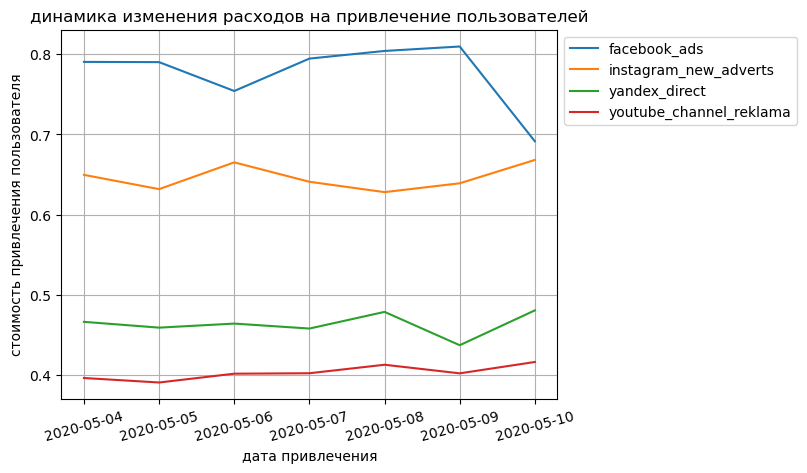

In [95]:
sns.lineplot(data=ad_costs_users, x="day", y="cac", hue="source")

plt.ylabel('стоимость привлечения пользователя')
plt.xlabel('дата привлечения')
plt.title('динамика изменения расходов на привлечение пользователей')
plt.grid()
plt.xticks(rotation = 15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

САС для разных каналов колебался не сильно. Только для 'facebook_ads' стоимость сильно упала в последний день (возможно, падение последнего дня связано с малым объёмом закупки - появляется волатильность из-за малого числа данных).

---

### Предварительные выводы по исследовательскому анализу данных

- всего было привлечено 13576 пользователей;
- события:
    - среднее число событий на уникального пользователя: 10;
    - максимальное число событий на уникального пользователя: 22;
    - минимальное число событий на уникального пользователя: 1.
- чаще всего на пользователя приходится 6, 10 или 12 событий. Мы высянили, что несколько пиков самых частых значений связаны с типом прохождения уровня - для мирного типа требуется больше собтыий и больше 10, тогда как чтобы пройти воинственным путем, много событий не требуется;
- 13.7% пользователей завершили уровень постройкой спутника, а победой над врагом завершило 29.1% пользователей;
- среднее время проведенное на первом уровне зависит от способа прохождения: 
    - разница между первым и последним событием для тех, кто не прошел уровень - в среднем 234 часа;
    - для тех, кто прошел уровень победой над соперником - 266 часов; 
    - для тех, кто прошел постройкой спутника - 323 часа;
    - Минимальное количество часов для прохождения мирным путем - 123, путем победы над врагом - 10.
- также и события на пользователя - для тех кто не прошел - событий меньше (в среднем 8), прошли победой над врагом - 10, постройкой спутника - 14; 
- мирные пользователи строили в среднем 12 построек, воинственные - 9, те, кто не прошел - 8;
- минимальное число событий для прохождения постройкой спутника - 12, для победы над врагом - 3;
- по распределению типов построек: 
    - среднее число построек для всех типов выше всего у пользователей, которые строили спутник;
    - самое низкое среднее значение для всех типов, кроме 'research_center' - среди пользователей, не завершивших уровень; 
    - самое большое значение среднего числа построек у 'spaceport' для тех, кто завершил уровень мирно;
    - се самое низкое среднее значение 'research_center' для пользвоателей, не прошедших первый уровень, - это может быть инересным инсайтом для заказчика: пользователи достаточно много строили здания такого типа, но все равно не прошли уровень - может быть они столкнулись с какими-либо трудностями или им стало неинтересно так долго продолжать игру? 
- между количеством часов от первого до последнего действия на уровне и количеством событий есть достаточно сильная корреляция. Однако она почти отсутсвует для пользователей, которые строили спутник - это связано с тем, что им по умолчанию приходится строить больше зданий (среди количества событий для пользователей, завершивших уровень таким образом нет значения ниже 10).
- гурппировка пользователей по датам привлечения показала: 
    - общее количество привлеченных пользоваетелй падало изо дня в день;
    - доля не закончивших уровень пользователей росло изо дня в день;
    - доля мирных пользователей сокращалась изо дня в день (кроме 9 мая); 
    - доля воинственных пользователей слегка колебалась, но оставалась примерно на одном уровне для каждого дня привлечения;
    - среднее количество действий на пользователя снижалось изо дня в день, но не сильно. 
- исследование каналов привелчения показало:
    - доли привлеченных пользователей распределены неравномерно, при этом они не сильно менялись изо дня в день: 
        - 'yandex_direct' - 35%;
        - 'instagram_new_adverts' - 25%;
        - 'facebook_ads' - 20%;
        - 'youtube_channel_reklama' - 20%.
    - при этом затраты на привлечение распределены иным образом: 
        - 'yandex_direct' - 29%;
        - 'instagram_new_adverts' - 28%;
        - 'facebook_ads' - 28%;
        - 'youtube_channel_reklama' - 14%.
    - показатель САС в целом устойчив изо дня в день и за весь приод привлечения выглядит так:
        - 'yandex_direct' - 0.5;
        - 'instagram_new_adverts' - 0.6;
        - 'facebook_ads' - 0.8;
        - 'youtube_channel_reklama' - 0.4.     


---
---

## Анализ влияния источника перехода в игру на поведение пользователя:

### Портрет пользователя в зависимости от канала привлечения

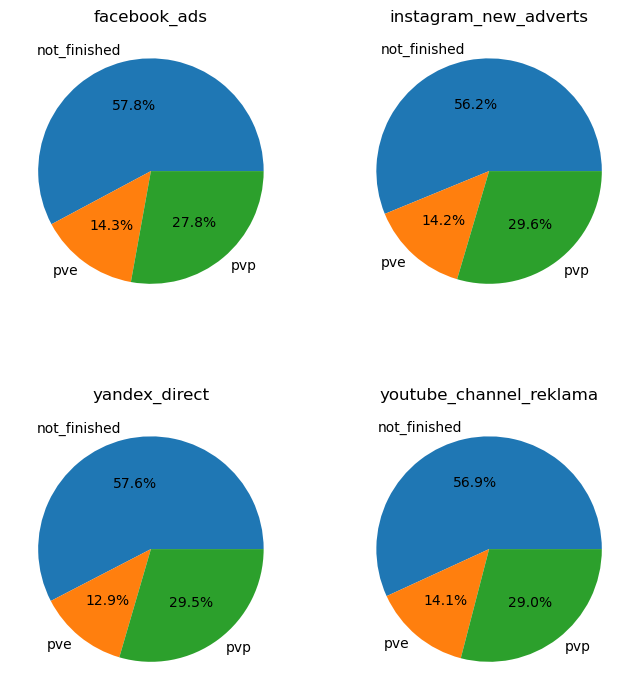

In [96]:
sources = ['facebook_ads', 'instagram_new_adverts', 'yandex_direct', 'youtube_channel_reklama']

fig, axs = plt.subplots(2, 2, figsize=(8,9))

for i, s in enumerate(sources): 
    nf = users.query('source == @s & level_finished == "not_finished"')
    pve = users.query('source == @s & level_finished == "pve"')
    pvp = users.query('source == @s & level_finished == "pvp"')
    values = [len(nf), len(pve), len(pvp)]
    labels = ['not_finished', 'pve', 'pvp']
    axs[int(i/2), i%2].pie(values, labels=labels, autopct='%1.1f%%')
    axs[int(i/2), i%2].set_title(s)
    

- Различия по конверсии в прохождение есть, но не сильные;
- Меньше всего мирных прохождений у канала yandex_direct - 13% (у остальных примерно по 14%);
- Меньше всего прошедших воинственным путем - среди пользователей с канала facebook_ads - 27% (у остальных примерно по 29%).

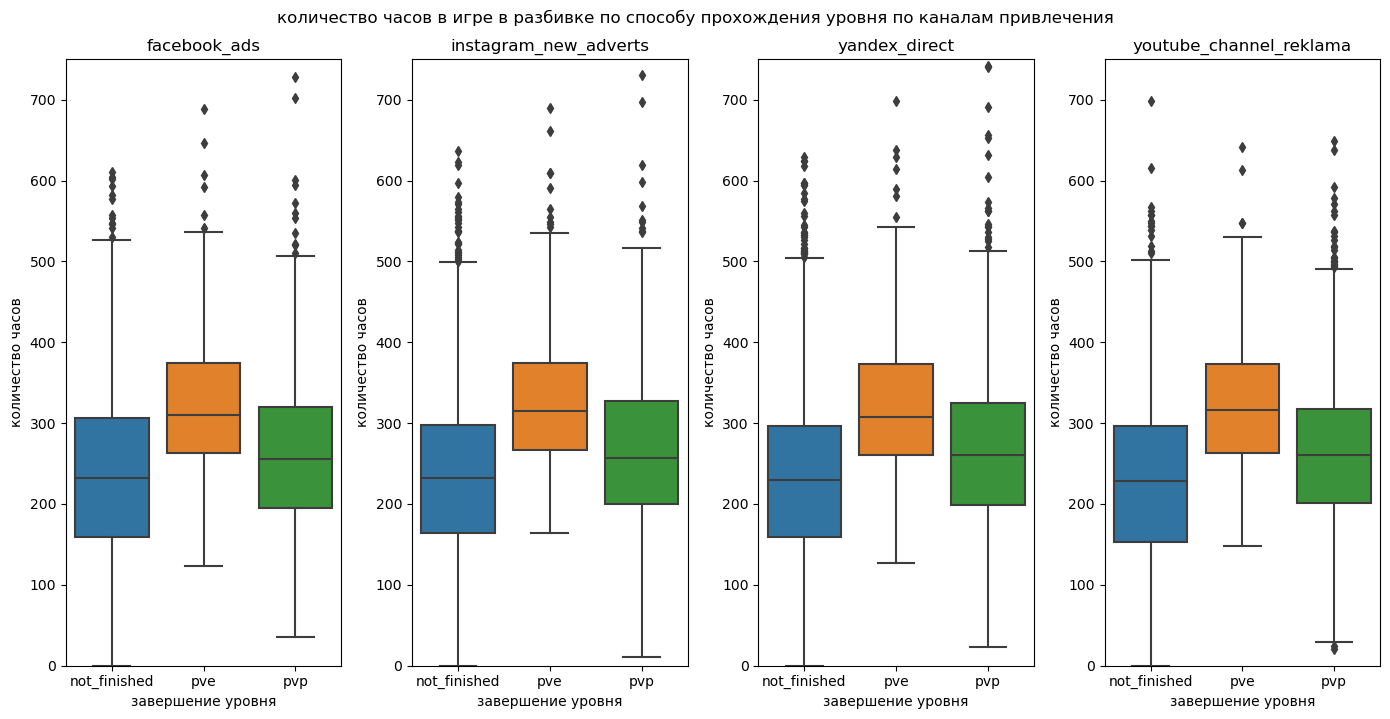

In [97]:
fig, axes = plt.subplots(1, 4, figsize=(14,7))

for i, s in enumerate(sources):
    ax = axes[i]
    sns.boxplot(
        data=users.query('source == @s').sort_values(by='level_finished'),
        x='level_finished',
        y='hours',
        ax=ax)
    ax.set_title(s)
    ax.set(xlabel='завершение уровня')
    ax.set(ylabel='количество часов')
    ax.set(ylim=(0, 750))
    plt.tight_layout()
    
fig.suptitle('количество часов в игре в разбивке по способу прохождения уровня по каналам привлечения', y=1.02);

В целом количество часов в игре очень схоже для всех источников привлечения. 

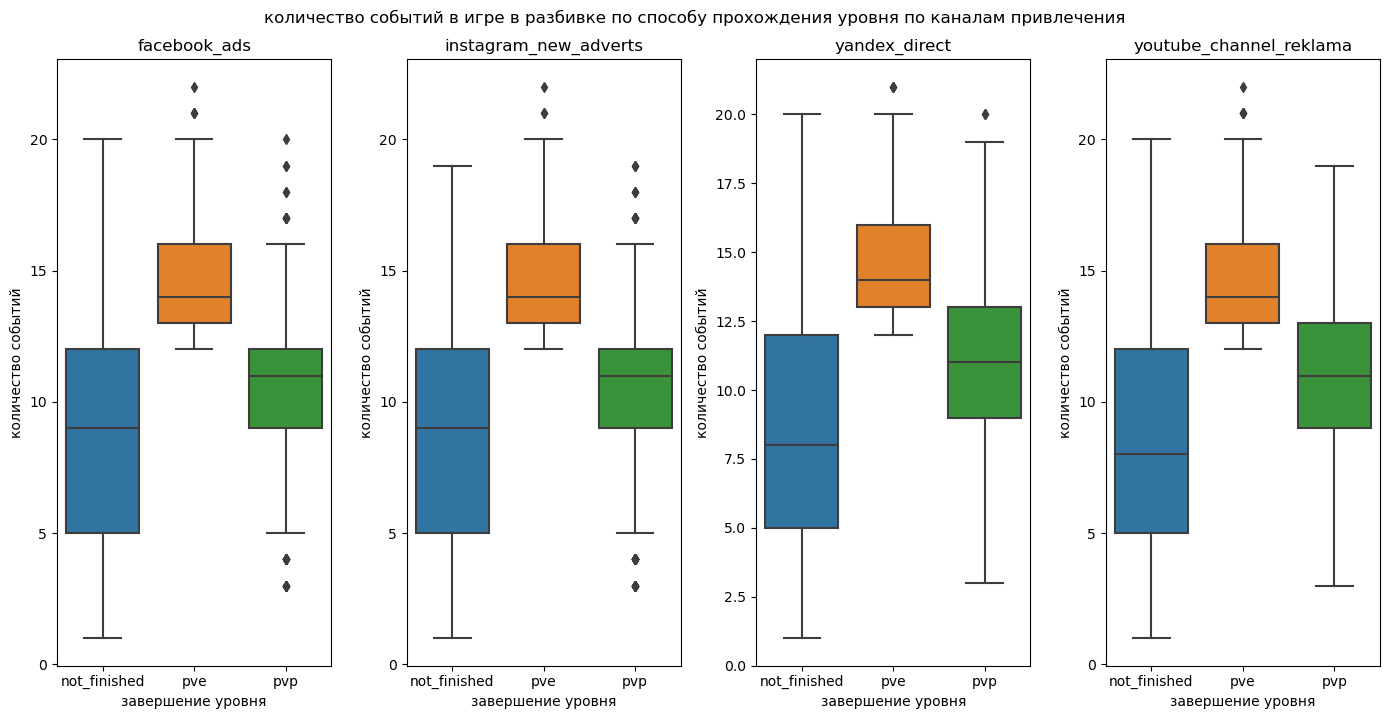

In [98]:
fig, axes = plt.subplots(1, 4, figsize=(14,7))

for i, s in enumerate(sources):
    ax = axes[i]
    sns.boxplot(
        data=users.query('source == @s').sort_values(by='level_finished'),
        x='level_finished',
        y='number_of_events',
        ax=ax)
    ax.set_title(s)
    ax.set(xlabel='завершение уровня')
    ax.set(ylabel='количество событий')
    plt.tight_layout()
    
fig.suptitle('количество событий в игре в разбивке по способу прохождения уровня по каналам привлечения', y=1.02);

- Для количества событий тоже схожее изображение для всех источников привлечения;
- небольшое различие можно наблюдать только для воинственных игроков, привлеченных каналами yandex_direct и youtube_channel: 
    - нормальные значения шире и нет выбросов в нижней части графика; 
    - почти нет выбросов и в верхней части графика

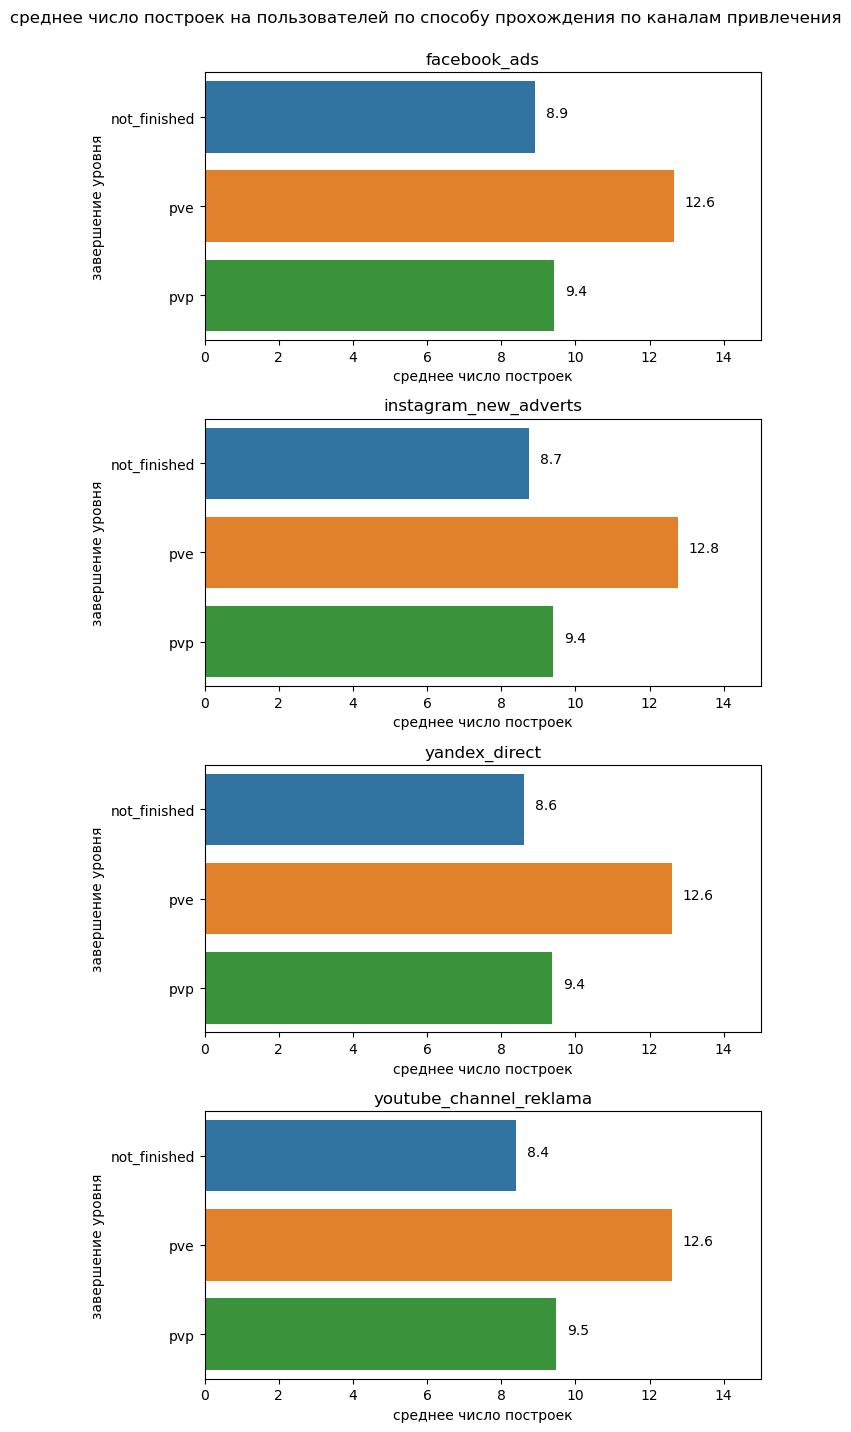

In [99]:
fig, axes = plt.subplots(4, 1, figsize=(7,14))

for i, s in enumerate(sources):
    
    values = [
    users.query('source == @s & level_finished =="not_finished"')['number_of_buildings'].mean(), 
    users.query('source == @s & level_finished =="pve"')['number_of_buildings'].mean(), 
    users.query('source == @s & level_finished =="pvp"')['number_of_buildings'].mean()
    ]
    
    labels = [
    'not_finished',
    'pve', 
    'pvp'
    ]
    
    ax = axes[i]
    sns.barplot(x=values,
                y=labels,
                ax=ax)    
    ax.set_title(s)
    ax.set(xlabel='среднее число построек')
    ax.set(ylabel='завершение уровня')
    ax.set(xlim=(0, 15))
    show_values(ax, "h", space=0.3)
    plt.tight_layout()
    
fig.suptitle('среднее число построек на пользователей по способу прохождения по каналам привлечения', y=1.02);

В этом разрезе данных также не удается разглядеть каких-либо особых различий для пользователей из разных групп.

In [100]:
buildings = game_actions.pivot_table(index=('user_id','building_type') , values='event', aggfunc='count').reset_index()
buildings_users = buildings.merge(users, on='user_id')
buildings_users = buildings_users.pivot_table(index=('building_type', 'level_finished', 'source'), values='event', aggfunc='mean').reset_index()
buildings_users = buildings_users.sort_values(by='event', ascending=False)

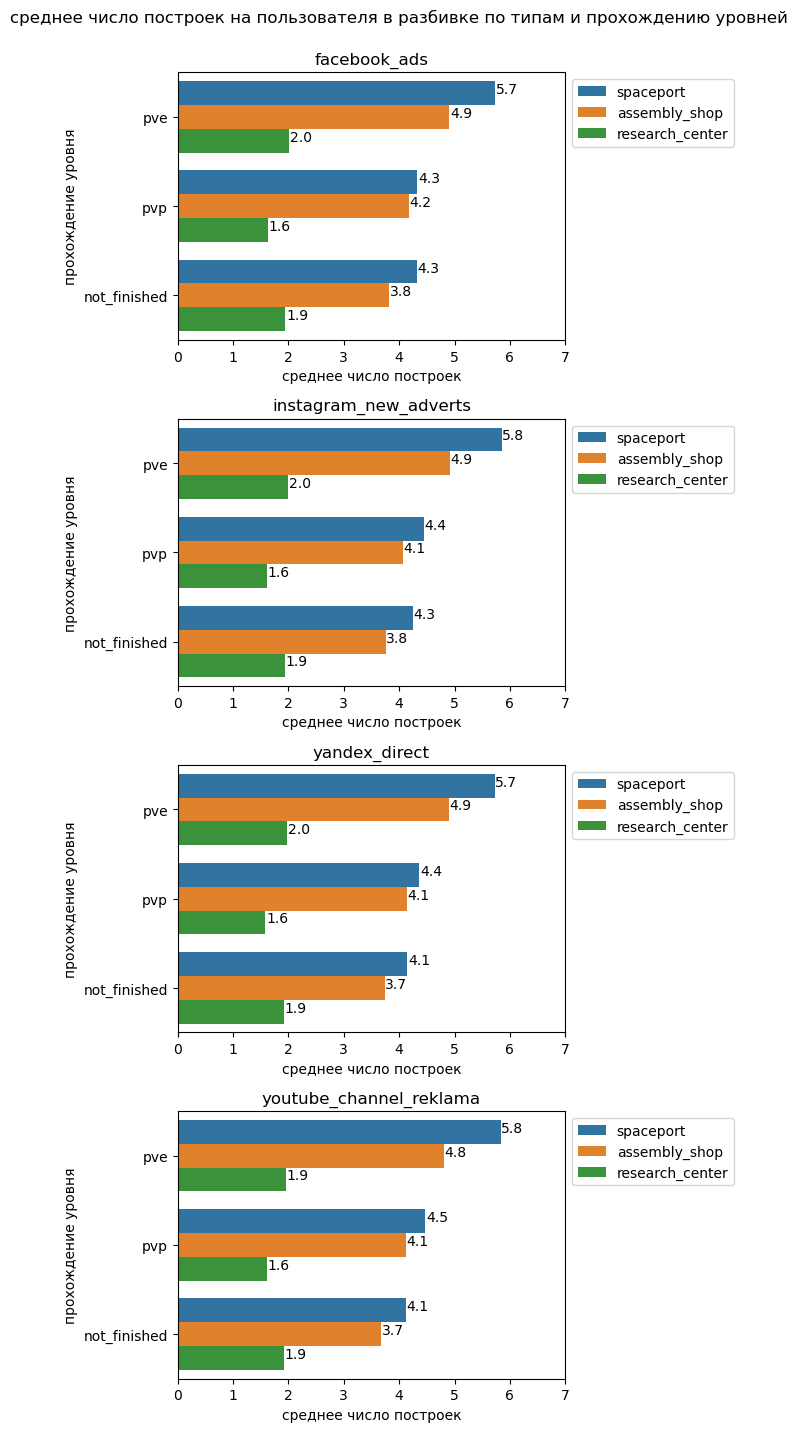

In [101]:
fig, axes = plt.subplots(4, 1, figsize=(7,14))

for i, s in enumerate(sources):
    ax = axes[i]
    ax = sns.barplot(
        x='event',
        y='level_finished',
        data=buildings_users.query('source == @s'),
        hue='building_type',
        ax=ax
    )
    ax.set_title(s)
    ax.set(xlabel='среднее число построек')
    ax.set(ylabel='прохождение уровня')
    show_values(ax, "h")
    ax.set(xlim=(0, 7))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    
fig.suptitle('среднее число построек на пользователя в разбивке по типам и прохождению уровней', y=1.02);

В этом случае так же не сильно значимые расхождения для пользователей из разных каналов. 

---

### Предварительные выводы по взаимосвязи поведения пользователя и канала привлечения

**Как от канала привлечения зависит конверсия привлеченных пользователей в прошедших первый уровень?**

- конверсии в прохождение первого уровня для пользователей, привелченных каналами *instagram_new_adverts* и *youtube_channel_reklama*, немного выше остальных - в районе 44%;
- наименьшая доля игроков, закончивших уровень постройкой спутника - у *yandex_direct* - около 13% (у остальных чуть больше 14%). 
- меньше всего пользователей, прошедших путем победы над соперником, привелчено каналом facebook_ads - 27% (у остальных примерно по 29%). 
- в целом конверсии в прохождение первого уровня очень похожи, поэтому предварительно можно сделать вывод, что конверсия примерно одинаковая дла пользователей со всех каналов.

**Как от канала привлечения зависит то, как долго пользователи проходили первый уровень?**

- в целом среднее время проведенное в игре на первом уровне примерно похоже для всех каналов;

**Как от канала привлечения зависит то, сколько событий приходится на пользователя?**

- количество событий на первом уровне игры схоже для пользователей со всех каналов;
- небольшое различие можно наблюдать только для игроков, прошедших уровень победой над соперником и привлеченных каналами yandex_direct и youtube_channel: 
    - нормальные значения шире и нет выбросов в нижней части графика; 
    - почти нет выбросов и в верхней части графика.
    
    Это говорит лишь о том, что игрокам с этих двух каналов, прошедшие уровень путем победы, потребовалось примерно одинаковое количество времени.

**Как от канала привлечения зависит то, сколько зданий строят пользователи?**

- в целом среднее количество зданий на игрока примерно похоже для всех каналов.

**Как от канала привлечения зависит то, как распределены типы зданий, которые строят пользователи?**

- в целом распределение количества зданий примерно похоже для всех каналов и схоже с обнаруженными закономерностями для всего датасета в разбивке по типам завершения уровня.

**-> Итак, в целом поведение пользователей очень похоже для всех каналов - различия в средних показателях очень небольшие.**

---
---

## Проверка статистических гипотез

### Время завершения уровня различается в зависимости способа прохождения

*время завершения уровня различается в зависимости способа прохождения:*
- через реализацию проекта,
- через победу над первым игроком.

-> H0: разницы между средним временем прохождения первого уровня для двух способов нет;        
-> Н1: разница между средним временем прохождения первого уровня для двух способов есть.

In [102]:
# срезы данных
pve = users.query('level_finished == "pve"')['hours']
pvp = users.query('level_finished == "pvp"')['hours']

# проводим т-тест для двух независимых выборок
res = st.ttest_ind(pve, pvp, equal_var=False)

# уровень значимости установим на уровне 5%
alpha = .05


print(f'p-value: {res.pvalue}')

if res.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу, разница между средним временем прохождения первого уровня для двух способов есть')
else: 
    print('Не получилось отвергнуть нулевую гипотезу, разницы между средним временем прохождения первого уровня для двух способов нет')

p-value: 5.824266018782012e-107
Отвергаем нулевую гипотезу, разница между средним временем прохождения первого уровня для двух способов есть


Значение p-value получилось очень малым, а значит мы должны отвергнуть нулевую гипотезу и принять альтернативную: разница между средним временем проходения первого уровня для двух способов есть. 

Однако мы помним, что среди значений количества событий на пользователя могли быть выбросы. Есть основания считать, что стоит убрать выбросы именно среди собтиый, потому что между колчиеством событий и временем в игре есть прямая связь, а еще так мы не уберем пользователей, который действительно долго проходили уровень, хотя совершили обычное количество событий.

Используем 99-й персентиль.

In [103]:
display(np.percentile(users['number_of_events'], 99))

19.0

Отсеим пользователей, которые совершили не больше 19 событий.

In [104]:
# новые срезы данных
pve = users.query('number_of_events <= 19 & level_finished == "pve"')['hours']
pvp = users.query('number_of_events <= 19 & level_finished == "pvp"')['hours']


# проводим т-тест для двух независимых выборок
res = st.ttest_ind(pve, pvp, equal_var=False)

# уровень значимости установим на уровне 5%
alpha = .05


print(f'p-value: {res.pvalue}')

if res.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу, разница между средним временем прохождения первого уровня для двух способов есть')
else: 
    print('Не получилось отвергнуть нулевую гипотезу, разницы между средним временем прохождения первого уровня для двух способов нет')

p-value: 3.387187825894447e-104
Отвергаем нулевую гипотезу, разница между средним временем прохождения первого уровня для двух способов есть


Даже несмотря на то, что мы устранили выбросы по числу событий на пользователя, все равно приходится отвергнуть нулевую гипотезу в пользу альтернативной и признать, что разница есть

In [105]:
print(
    "относительное преимущество количества среднего времени прохождения для мирного способа: {0:.3f}"
    .format(pve.mean() / pvp.mean() - 1)
     )

относительное преимущество количества среднего времени прохождения для мирного способа: 0.211


---

### Доля уникальных пользователей выбирающих тот или иной способ прохождения различается в зависимости от канала привлечения

*доля уникальных пользователей выбирающих тот или иной способ прохождения различается в зависимости от канала привлечения:*

        - 'facebook_ads'; 
        - 'instagram_new_adverts';
        - 'yandex_direct';
        - 'youtube_channel_reklama'.

-> H0: разницы между долями уникальных пользователей прошедших уровень первым или вторым способом   для разных каналов нет;         
-> H1: разница между долями уникальных пользователей прошедших уровень первым или вторым способом   для разных каналов есть.

Для проверки гипотезы будем использовать статистический тест для проверки равенства долей. Необходимо будет провести шесть проверок для сравнения долей одного из типов прохождения.

In [106]:
# создаем датафрейм с долями количества пользователей прошедших уровень

lvl_finished_grouped = (
    users
    .query('level_finished != "not_finished"')
    .pivot_table(index=('level_finished', 'source'), values='user_id', aggfunc='count')
    .reset_index()
)

lvl_finished_source = (
    users
    .query('level_finished != "not_finished"')
    .pivot_table(index=('source'), values='user_id', aggfunc='count')
    .reset_index()
)

lvl_finished_grouped = lvl_finished_grouped.merge(lvl_finished_source, on='source')

lvl_finished_grouped['share, %'] = (
    (lvl_finished_grouped['user_id_x'] / lvl_finished_grouped['user_id_y'])
    .round(3) * 100
)

lvl_finished_grouped = (
    lvl_finished_grouped
    .rename(columns={'user_id_x':'finished_type_users', 'user_id_y':'finished_per_source'})
)

lvl_finished_grouped

,level_finished,source,finished_type_users,finished_per_source,"share, %"
0,pve,facebook_ads,391,1150,34.0
1,pvp,facebook_ads,759,1150,66.0
2,pve,instagram_new_adverts,476,1466,32.5
3,pvp,instagram_new_adverts,990,1466,67.5
4,pve,yandex_direct,620,2042,30.4
5,pvp,yandex_direct,1422,2042,69.6
6,pve,youtube_channel_reklama,379,1159,32.7
7,pvp,youtube_channel_reklama,780,1159,67.3


In [107]:
# так как у нас всего два варианта завершения уровня, 
# мы можем сравнить доли по группам только какого-нибудь одного

lvl_finished_grouped_pve = lvl_finished_grouped.query('level_finished == "pve"')

In [108]:
# функция для проведения теста для сравнения долей

def z_tester(n1, d1, n2, d2, s1, s2, alpha):
    '''
     Функция принимает значение количества пользователей, общее число пользователей,
     названия источников и значение alpha.
     Функция проводит z-test, сравнивая доли уникальных пользователей от общего числа по источникам
     и выдает результат в соответсвии с заданным значением alpha.
    '''

    p1 = n1/d1
    p2 = n2/d2
    p_combined = (n1 + n2) / (d1 + d2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/d1 + 1/d2))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2


    if p_value < alpha: 
        print(
            f' сравнение источников {s1} и {s2} по долям пользователей, прошедших первый уровень:','\n',
            '\n H0 - разницы между двумя долями нет\n',
            'H1 - разница между двумя долями есть\n',
            ' -------------------------------------- \n',
            'p-value для сравнения долей:', round(p_value, 3),'\n', 
            'отвергаем Н0 - есть основания считать, что значимая разница между долями есть\n'
            '\n****************************************************************************',
            '\n'
            )
    else: 
        print(
            f' сравнение источников {s1} и {s2} по долям пользователей, прошедших первый уровень:','\n',
            '\n H0 - разницы между двумя долями нет\n',
            'H1 - разница между двумя долями есть\n',
            ' --------------------------------------- \n',
            'p-value для сравнения долей:', round(p_value, 3),'\n',
            'принимаем Н0 - есть основания считать, что значимой разницы между долями нет\n'
            '\n****************************************************************************',
            '\n'
            )
    return 

In [109]:
# проходим циклом по списку списков сочетаний двух источников - всего 6 вариантов

sources = [
    ['facebook_ads','instagram_new_adverts'],
    ['facebook_ads','yandex_direct'],
    ['facebook_ads','youtube_channel_reklama'],
    ['instagram_new_adverts','yandex_direct'],
    ['instagram_new_adverts','youtube_channel_reklama'],
    ['youtube_channel_reklama','yandex_direct']
]
    

for s in sources:
    n1 = int(lvl_finished_grouped_pve.query('source == @s[0]')['finished_type_users'])
    d1 = int(lvl_finished_grouped_pve.query('source == @s[0]')['finished_per_source'])
    n2 = int(lvl_finished_grouped_pve.query('source == @s[1]')['finished_type_users'])
    d2 = int(lvl_finished_grouped_pve.query('source == @s[1]')['finished_per_source'])
    s1 = s[0]
    s2 = s[1]
#   так как у нас шесть сравнений, то нужно понизить значения alpha в шесть раз по поправке Бонферрони
    alpha = .05 / 6
    z_tester(n1, d1, n2, d2, s1, s2, alpha)


 сравнение источников facebook_ads и instagram_new_adverts по долям пользователей, прошедших первый уровень: 
 
 H0 - разницы между двумя долями нет
 H1 - разница между двумя долями есть
  --------------------------------------- 
 p-value для сравнения долей: 0.409 
 принимаем Н0 - есть основания считать, что значимой разницы между долями нет

**************************************************************************** 

 сравнение источников facebook_ads и yandex_direct по долям пользователей, прошедших первый уровень: 
 
 H0 - разницы между двумя долями нет
 H1 - разница между двумя долями есть
  --------------------------------------- 
 p-value для сравнения долей: 0.034 
 принимаем Н0 - есть основания считать, что значимой разницы между долями нет

**************************************************************************** 

 сравнение источников facebook_ads и youtube_channel_reklama по долям пользователей, прошедших первый уровень: 
 
 H0 - разницы между двумя долями нет
 H1 - р

Ни для одной из пар мы не получили значимых результатов. Таким образом, есть основания считать, что для всех каналов привлечения пользователи ведут себя примерно одинаково и способ завершения уровня не зависит от канала привлечения.

---

### Выводы по статистическим гипотезам

1. Разница между средним временем прохождения первого уровня для двух способов есть.
    - это подтверждают и выводы из исследовательского анализа данных. Для прохождения уровня методом постройки спутника, требуется в среднем большее число событий, чем для другого способа прохождения. Кроме того, мы выяснили, что пользователи не могут пройти уровень способом постройки спутника менее чем за 10 событий. Так как между количеством событий и временем между первым и последним действием в уровне есть прямая связь, то для постройки спутника требуется больше времени. Также важно заметить, что такие пользователи больше строят здания. Возможно из-за того, что приходится совершать много действий, доля пользователей, построивших спутник меньше всего. 
    
2. Разницы между долями пользователей завершивших первый уровень в сравнении по каналам привелчения нет. 
    - этот вывод подтверждается еще и тем, что мы обнаружили ранее, когда сравнивали поведение пользователей по каналам привлечения: особой разницы между поведением нет. Таким образом можно сказать, что никакие показатели, и в особенности доля пользователей, прошедших уровень, не зависят от канала привелчения - все каналы привелкают примерно одинаковых пользователей.
    
    
---
---

## Выводы

Мы проделали следующую работу: декомпозировали задачу проекта и составили план; сохранили датасеты ad_costs, game_actions и user_source и выполнили предобработку данных; выполнили исследовательский анализ данных датасетов с действиями пользователей и затрат на привлечение; после этого мы проанализировали влияние источника перехода в игру на поведение пользователей и проверили две статистические гипотезы. В завершении мы оформили общие выводы и составили презентацию по исследованию. 

---

1. **Исследовательский анализ данных:**

- всего было привлечено 13576 пользователей;
- события:
    - среднее число событий на уникального пользователя: 10;
    - максимальное число событий на уникального пользователя: 22;
    - минимальное число событий на уникального пользователя: 1.
- чаще всего на пользователя приходится 6, 10 или 12 событий. Мы высянили, что несколько пиков самых частых значений связаны с типом прохождения уровня - для мирного типа требуется больше собтыий и больше 10, тогда как чтобы пройти воинственным путем, много событий не требуется;
- 13.7% пользователей завершили уровень постройкой спутника, а победой над врагом завершило 29.1% пользователей;
- среднее время проведенное на первом уровне зависит от способа прохождения: 
    - разница между первым и последним событием для тех, кто не прошел уровень - в среднем 234 часа;
    - для тех, кто прошел уровень победой над соперником - 266 часов; 
    - для тех, кто прошел постройкой спутника - 323 часа;
    - Минимальное количество часов для прохождения мирным путем - 123, путем победы над врагом - 10.
- также и события на пользователя - для тех кто не прошел - событий меньше (в среднем 8), прошли победой над врагом - 10, постройкой спутника - 14; 
- мирные пользователи строили в среднем 12 построек, воинственные - 9, те, кто не прошел - 8;
- минимальное число событий для прохождения постройкой спутника - 12, для победы над врагом - 3;
- по распределению типов построек: 
    - среднее число построек для всех типов выше всего у пользователей, которые строили спутник;
    - самое низкое среднее значение для всех типов, кроме 'research_center' - среди пользователей, не завершивших уровень; 
    - самое большое значение среднего числа построек у 'spaceport' для тех, кто завершил уровень мирно;
    - се самое низкое среднее значение 'research_center' для пользвоателей, не прошедших первый уровень, - это может быть инересным инсайтом для заказчика: пользователи достаточно много строили здания такого типа, но все равно не прошли уровень - может быть они столкнулись с какими-либо трудностями или им стало неинтересно так долго продолжать игру? 
- между количеством часов от первого до последнего действия на уровне и количеством событий есть достаточно сильная корреляция. Однако она почти отсутсвует для пользователей, которые строили спутник - это связано с тем, что им по умолчанию приходится строить больше зданий (среди количества событий для пользователей, завершивших уровень таким образом нет значения ниже 10).
- гурппировка пользователей по датам привлечения показала: 
    - общее количество привлеченных пользоваетелй падало изо дня в день;
    - доля не закончивших уровень пользователей росло изо дня в день;
    - доля мирных пользователей сокращалась изо дня в день (кроме 9 мая); 
    - доля воинственных пользователей слегка колебалась, но оставалась примерно на одном уровне для каждого дня привлечения;
    - среднее количество действий на пользователя снижалось изо дня в день, но не сильно. 
- исследование каналов привелчения показало:
    - доли привлеченных пользователей распределены неравномерно, при этом они не сильно менялись изо дня в день: 
        - 'yandex_direct' - 35%;
        - 'instagram_new_adverts' - 25%;
        - 'facebook_ads' - 20%;
        - 'youtube_channel_reklama' - 20%.
    - при этом затраты на привлечение распределены иным образом: 
        - 'yandex_direct' - 29%;
        - 'instagram_new_adverts' - 28%;
        - 'facebook_ads' - 28%;
        - 'youtube_channel_reklama' - 14%.
    - показатель САС в целом устойчив изо дня в день и за весь приод привлечения выглядит так:
        - 'yandex_direct' - 0.5;
        - 'instagram_new_adverts' - 0.6;
        - 'facebook_ads' - 0.8;
        - 'youtube_channel_reklama' - 0.4.     

2. **Выводы по влиянию источника перехода в игру на поведение пользователей:**

- Поведение пользователей очень похоже для всех каналов - различия в средних показателях очень небольшие
- Это заключение подтверждает и вывод по проверке статистической гипотезы о равентсве долей пользователей, выбирающих тот или иной способ прохождения: нет оснований считать, что доли отличаются для разных каналов, иными словами все каналы привлекают игроков, выбирающих способ прохождения примерно в равных пропорциях.

3. **Выводы по статистическим гипотезам:**

    - *Разница между средним временем прохождения первого уровня для двух способов есть.*
        - было замечено, что для постройки спутника требуется в среднем больше событий; и даже если для группы пользователей, которые строили спутник, нет сильной связи между количеством событий и временем на первом уровне, времени на прохождение данным способом в среднем требуется больше. Это подтверждается как по "сырым" данным, так.и по "очищенным" от аномалий - пользователей с нетипично большим временем в игре.

    - *Разницы между долями пользователей завершивших первый уровень в сравнении по каналам привелчения нет.*
        - этот вывод подкрепляет предыдущие заключения о схожем поведении пользователей: особой разницы разных каналов нет. Таким образом можно сказать, что никакие показатели, и в особенности доля пользователей, прошедших уровень, не зависят от канала привелчения - все каналы привелкают примерно одинаковых по поведению пользователей.


4. **Дополнительные выводы и рекомендации для заказчика:**

- так как компания собирается размещать рекламу в меню выбора типа постройки, а больше всего строят пользователи, которые проходят уровень созданием спутника, стоит задуматься об увеличении конверсии пользователей именно в этот тип (сейчас они занимают наименьшую долю среди всех);
- низкая конверсия в способ прохождения постройкой спутника, а так же достаточно высокое среднее число зданий, которые строили пользователи, не прошедшие уровень (не сильно меньше, чем у тех, кто прошел способом победы; а для типа зданий, по-видимому, характерного для постройки спутника - даже выше), может говорить о том, что пользователи либо сталкиваются с какими-то трудностями в прохождении, либо им неинтересно строить так много зданий и они покидают игру. Этот момент заслуживает дополнительного более детального рассмотрения;
- так как особой разницы между пользователями из привлеченных каналов нет, то на данном, этапе без сведений о дополнительных метриках можно делать упор на каналы, которые просто обходятся дешевле - 'youtube_channel_reklama' и 'yandex_direct'.


- [презентация исследования](https://drive.google.com/file/d/1kWHMP9ssiZTdBdqage725TmwvDyUFqK_/view?usp=sharing)
